# Gravitational orbits in Cartesian coordinates
---
general potential energy
\begin{align*}
   U(r) = k r^n
\end{align*}

\begin{align*}
   &F_x = -\frac{G m_1 m_2 (x_1 - x_2)}{r^3}\\
   &F_y = -\frac{G m_1 m_2 (y_1 - y_2)}{r^3}
\end{align*}

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Define the **GravitationalOrbits** class.
class GravitationalOrbits():
    '''
    The GravitationalOrbits class contains the parameters and Lagrange's equations for 
    two bodies orbiting due to gravitational attraction.
    _____________
    Parameters:
    m1 -- float, mass of first body 
    m2 -- float, mass of second body
    G  -- float, gravitational constant
    _____________
    Methods: 
    dz_dt(t, z) -- Returns the right side of the differential equation at a given time, t, and z value.
    
    '''
    def __init__(self, m1=1., m2=1., G=1.):
        '''
        Initializes the class attributes. 
        '''
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        '''
        Returns the right side of the differential equation:
        [dz/dt, d^2z/dt^2]
        ______________
        Parameters: 
        t -- float, time
        z -- float, vector where
             z[0] = x1, z[1] = x1_dot, z[2] = y1, z[3] = y1_dot
             z[4] = x2, z[5] = x2_dot, z[6] = y2, z[7] = y2_dot
        ______________
        Returns: 
        '''
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = z
        r12 = np.sqrt( (x2-x1)**2. + (y2-y1)**2. )  # distance between bodies
        f1 = self.G * self.m2 / r12**3.                     
        f2 = -self.G * self.m1 / r12**3.
        x12 = x2 - x1
        y12 = y2 - y1
        
        return [x1_dot, f1*x12, y1_dot, f1*y12, x2_dot, f2*x12, y2_dot, f2*y12]
    
    def solve_ode(self, t_pts, z_0, abserr=1.0e-10, relerr=1.0e-10):
        '''
        Solves the ODE given initial conditions using solve_ivp.
        '''
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts,
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def leapfrog(self, t_pts, z_0):
        '''
        Solves the ODE given initial conditions using Leapfrog method.
        '''
        delta_t = t_pts[1] - t_pts[0]
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
    
        # Create arrays with zeros, same length as t_pts
        num = len(t_pts)
        x1 = np.zeros(num)
        y1 = np.zeros(num)
        x2 = np.zeros(num)
        y2 = np.zeros(num)
        x1_dot = np.zeros(num)
        y1_dot = np.zeros(num)
        x2_dot = np.zeros(num)
        y2_dot = np.zeros(num)
        x1_dot_half = np.zeros(num)
        y1_dot_half = np.zeros(num)
        x2_dot_half = np.zeros(num)
        y2_dot_half = np.zeros(num)
        
        # Set up initial conditions
        x1[0] = x1_0
        y1[0] = y1_0
        x2[0] = x2_0
        y2[0] = y2_0
        x1_dot[0] = x1_dot_0
        y1_dot[0] = y1_dot_0
        x2_dot[0] = x2_dot_0
        y2_dot[0] = y2_dot_0
        
        # Step through diff eq
        for i in np.arange(num - 1):
            t = t_pts[i]
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
           
            x1_dot_half[i] = x1_dot[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot_half[i] = y1_dot[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot_half[i] = x2_dot[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot_half[i] = y2_dot[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            x1_dot[i+1] = x1_dot_half[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot[i+1] = y1_dot_half[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot[i+1] = x2_dot_half[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot[i+1] = y2_dot_half[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

Now we define a function for plotting.

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

And a function which returns stop and start indices for plotting. 

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [5]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o1 = GravitationalOrbits(m1=m1, m2=m2, G=G)

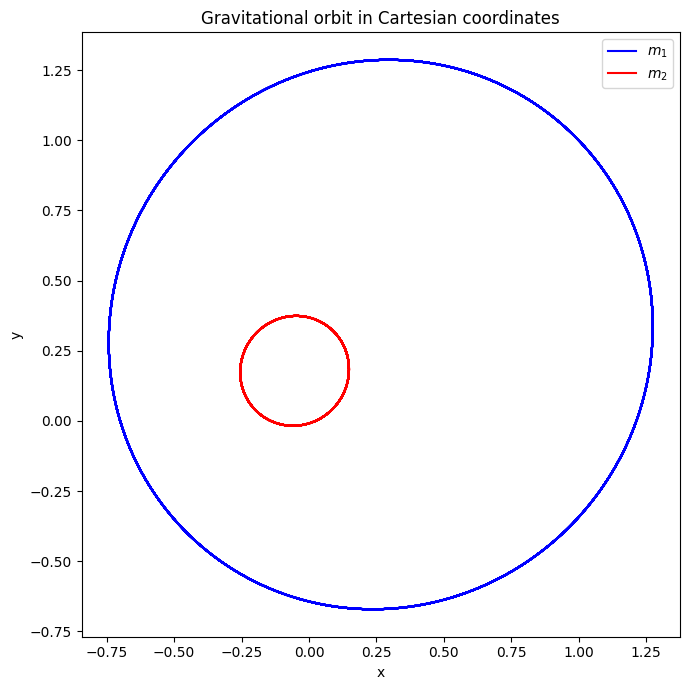

In [6]:
# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()

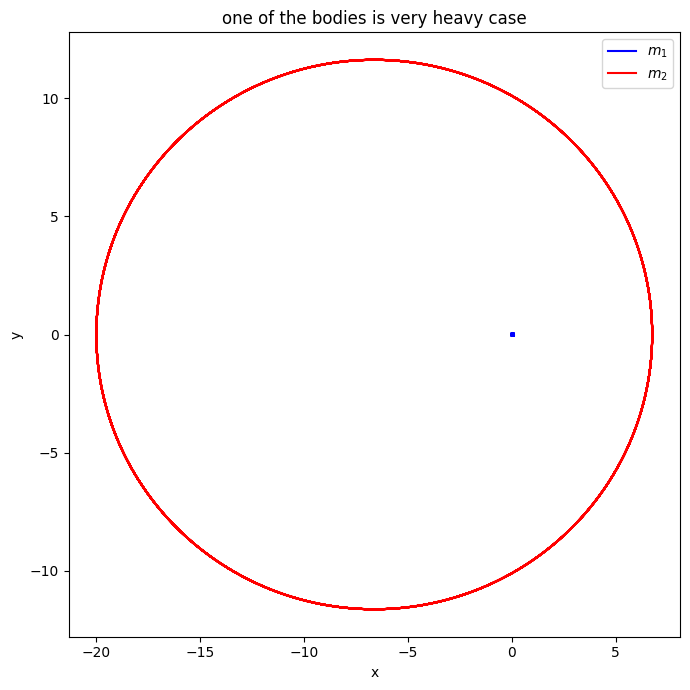

In [7]:
G = 20.0
m1 = 200.0
m2 = 1.0

o2 = GravitationalOrbits(m1=m1, m2=m2, G=G)

x1_0, x1_dot_0 = 0.1, 0.
y1_0, y1_dot_0 = 0., 0.05
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*y1_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('one of the bodies is very heavy case')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()

As expected, we see that in this case, the orbits are eliptical and much like those we saw in class.    

## Leapfrog method

In [8]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 30.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o4 = GravitationalOrbits(m1=m1, m2=m2, G=G)

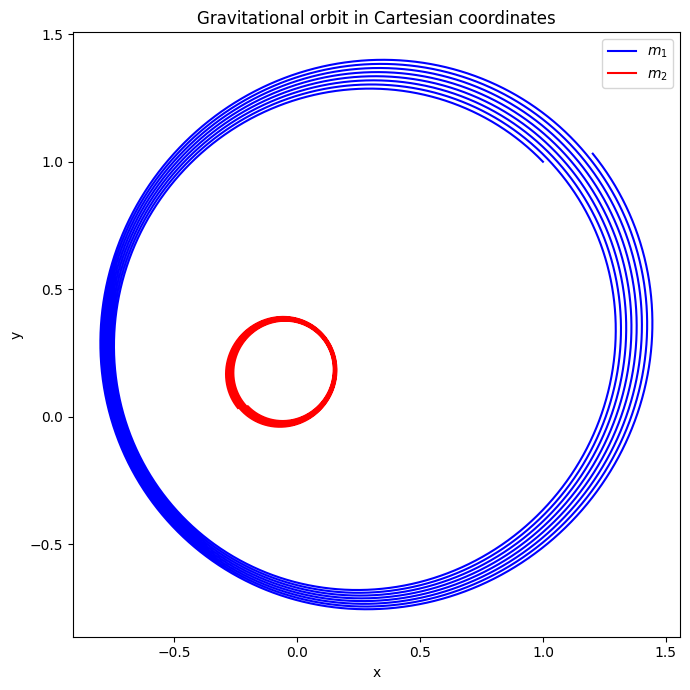

In [9]:
# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o4.leapfrog(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()

## Animation

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

In [11]:
def xy_coords(x0, y0, x, y):
    return x0 + x, y0 + y

In [ ]:
%%capture
x_min = -20.
x_max = 5.
y_min = -15.
y_max = -y_min

fig_anim = plt.figure(figsize=(5, 5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1, 1, 1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

x0, y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0, 'o', markersize=6, color='black')

x1, y1 = xy_coords(x0, y0, theta1[0], tp1.L1)
pt1_anim, = ax_anim.plot(x1, y1, 'o', markersize=12, color='blue')
ln1_anim, = ax_anim.plot([x0, x1], [y0, y1], color='blue', lw=3)

x2, y2 = xy_coords(x1, y1, theta2[0], tp1.L2)
pt2_anim, = ax_anim.plot(x2, y2, 'o', markersize=12, color='blue')
ln2_anim, = ax_anim.plot([x1, x2], [y1, y2], color='blue', lw=3)

x3, y3 = xy_coords(x2, y2, theta3[0], tp1.L3)
pt3_anim, = ax_anim.plot(x3, y3, 'o', markersize=12, color='blue')
ln3_anim, = ax_anim.plot([x2, x3], [y2, y3], color='blue', lw=3)

x1_s, y1_s = xy_coords(x0, y0, theta1_s[0], tp1.L1)
pt1_anim_s, = ax_anim.plot(x1_s, y1_s, 'o', markersize=12, color='red')
ln1_anim_s, = ax_anim.plot([x0, x1_s], [y0, y1_s], color='red', lw=3)

x2_s, y2_s = xy_coords(x1_s, y1_s, theta2_s[0], tp1.L2)
pt2_anim_s, = ax_anim.plot(x2_s, y2_s, 'o', markersize=12, color='red')
ln2_anim_s, = ax_anim.plot([x1_s, x2_s], [y1_s, y2_s], color='red', lw=3)

x3_s, y3_s = xy_coords(x2_s, y2_s, theta3_s[0], tp1.L3)
pt3_anim_s, = ax_anim.plot(x3_s, y3_s, 'o', markersize=12, color='red')
ln3_anim_s, = ax_anim.plot([x2_s, x3_s], [y2_s, y3_s], color='red', lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()